In [318]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [319]:
# 下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于{DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    # fname就是文件路径 e.g. ../data/fashion-mnist
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    # foler 可以理解为指定解压到哪个文件夹
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [320]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch 
from torch import nn
from d2l import torch as d2l

In [321]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# 1460 * 81
train_data = pd.read_csv(download('kaggle_house_train'))
# 1459 * 80
test_data = pd.read_csv(download('kaggle_house_test'))
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [322]:
# train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
train_data.head()
# test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [323]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 获取所有的数值类型的特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 将所有数值特征标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

# 处理缺失值为0（均值，因为进行了标准化）
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [324]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [325]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [326]:
loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )
    return net

# def get_net():
#     net = nn.Sequential(
#         nn.Linear(in_features, 1)
#     )
#     return net

# define the log rmse
def log_rmse(net, features, labels):
    # 为了在取对数的时候保持数值稳定，将小于1的数置为1
    clipped_pred = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_pred), 
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    train_ls, test_ls = [], []
    optimizer = torch.optim.Adam(net.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [327]:
# k折交叉验证切片函数
def get_k_fold_data(k, i, X ,y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, 
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, 
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], 
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], 
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.034659, 验证log rmse0.145526
折2，训练log rmse0.249824, 验证log rmse0.176338
折3，训练log rmse0.051632, 验证log rmse0.154165
折4，训练log rmse0.337868, 验证log rmse0.124043
折5，训练log rmse0.049658, 验证log rmse0.154958
5-折验证: 平均训练log rmse: 0.144728, 平均验证log rmse: 0.151006


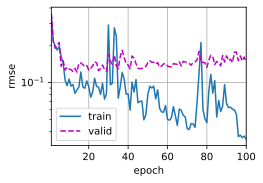

In [328]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, 
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [329]:
# submit for kaggle
def train_and_pred(train_features, train_labels, test_features, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.035428


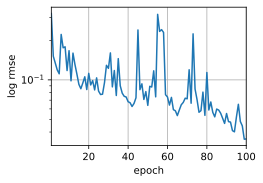

In [330]:
train_and_pred(train_features, train_labels, test_features, test_data,
               num_epochs, lr, weight_decay, batch_size)